In [30]:
import pandas as pd
import os
import numpy as np
from rpy2 import robjects
from rpy2.robjects import r,pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import xgboost
from sklearn.decomposition import PCA
import shap
import math
from scipy import stats
from sklearn.cluster import KMeans
from combat.pycombat import pycombat
os.environ["R_HOME"] = "/Library/Frameworks/R.framework/Resources" 
pandas2ri.activate()
limma = importr('limma')
stats = importr('stats')
warnings.filterwarnings("ignore")

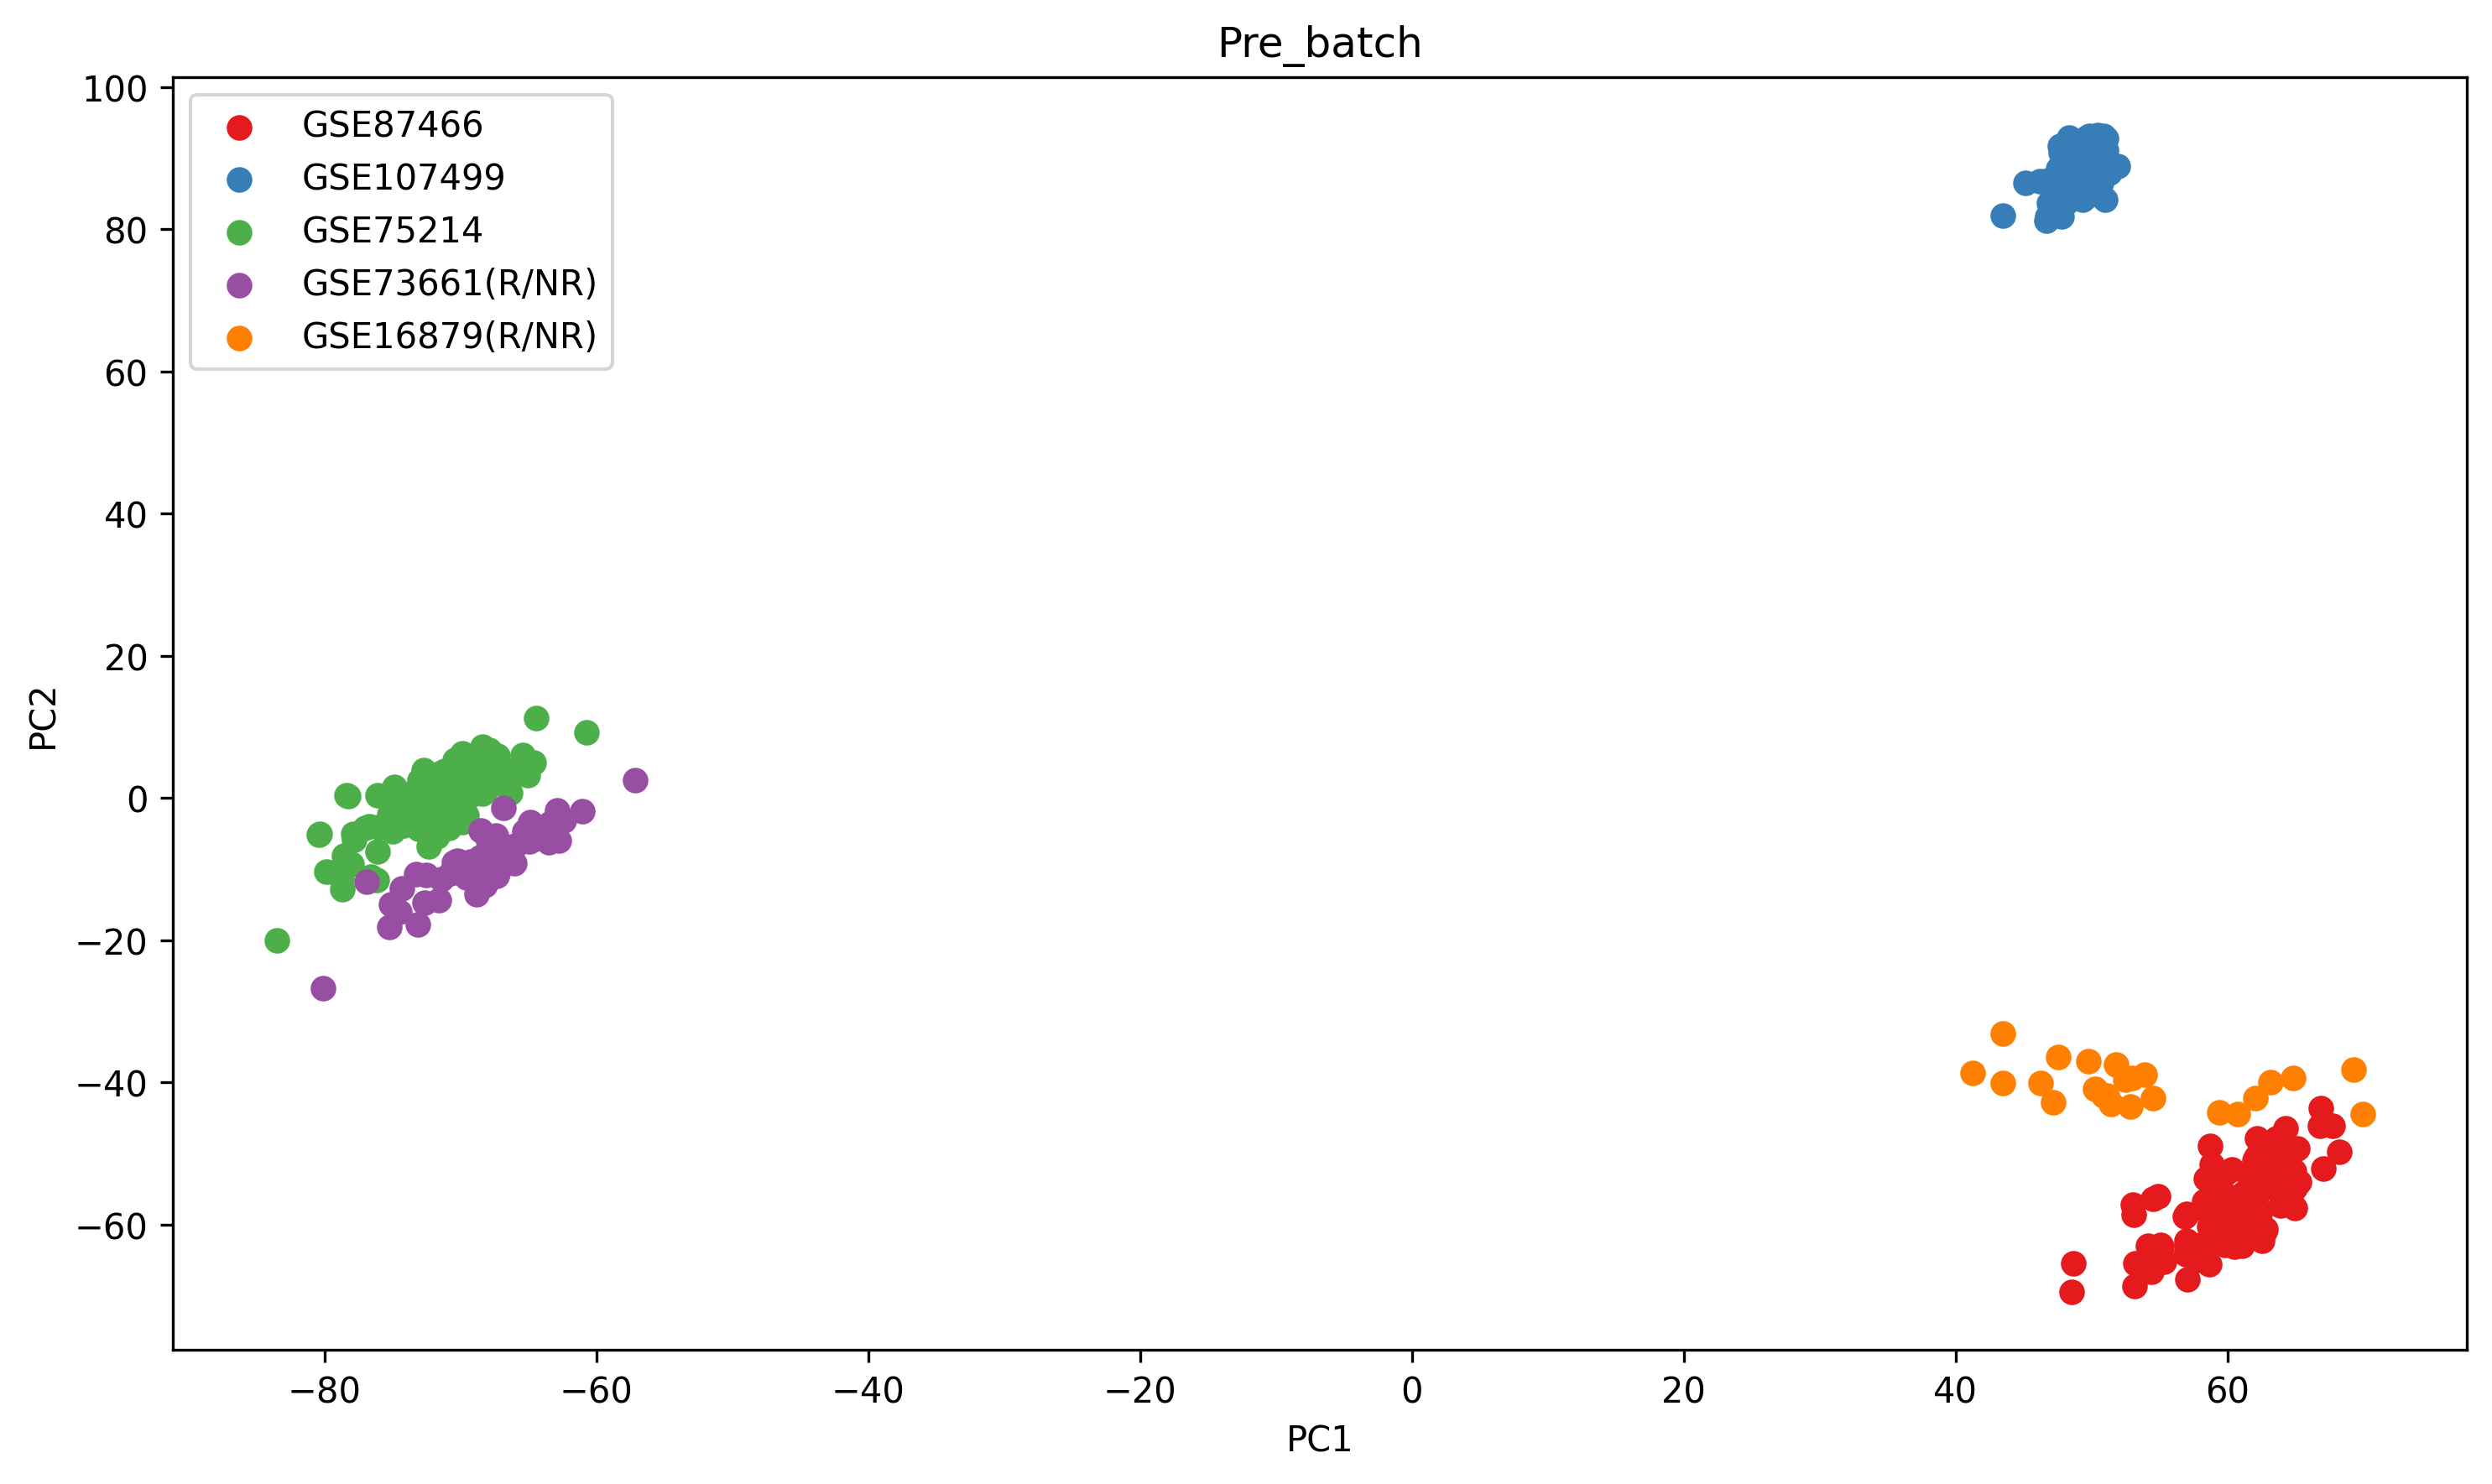

In [11]:
df1 = pd.read_csv("GSE87466.csv", header=0).drop(['label','sublabel'], axis=1)
df2 = pd.read_csv("GSE107499.csv", header=0).drop(['label'], axis=1)
df3 = pd.read_csv("GSE75214.csv", header=0).drop(['label','sublabel'], axis=1)
df4 = pd.read_csv("GSE73661_rightlabel.csv", header=0).drop(['label'], axis=1)
df5 = pd.read_csv("GSE16879.csv", header=0).drop(['label'], axis=1)
df1 = df1.rename(columns={'Unnamed: 0': 'id'}).drop(['id'], axis=1)
df2 = df2.rename(columns={'Unnamed: 0': 'id'}).drop(['id'], axis=1)
df3 = df3.rename(columns={'Unnamed: 0': 'id'}).drop(['id'], axis=1)
df4 = df4.rename(columns={'Unnamed: 0': 'id'}).drop(['id'], axis=1)
df5 = df5.rename(columns={'Unnamed: 0': 'id'}).drop(['id'], axis=1)
df5 = np.log2(df5 + 1)
common_columns = set(df1.columns) & set(df2.columns) & set(df3.columns) & set(df4.columns) & set(df5.columns)
df1 = df1[common_columns]
df2 = df2[common_columns]
df3 = df3[common_columns]
df4 = df4[common_columns]
df5 = df5[common_columns]
merged_df = pd.concat([df1, df2, df3, df4, df5])
arr = [0] * 108 + [1] * 87 + [2] * 108 + [3] * 64 + [4] * 24
color_mapping = {
    0: '#E41A1C',  
    1: '#377EB8',  
    2: '#4DAF4A',  
    3: '#984EA3', 
    4: '#FF7F00'  
}
colors = [color_mapping[label] for label in arr]
unique_labels = np.array(list(set(arr)))
legend_labels = ['GSE87466', 'GSE107499', 'GSE75214', 'GSE73661(R/NR)', 'GSE16879(R/NR)']
expression_before_batch = merged_df
pca = PCA(n_components=20)
PCA_dat_all = pca.fit_transform(expression_before_batch)

plt.figure(figsize=(10, 6), dpi=300)
for i, label in enumerate(unique_labels):
    plt.scatter(PCA_dat_all[arr == label, 0],
                PCA_dat_all[arr == label, 1],
                s=40,
                color=color_mapping[label],
                label=legend_labels[i])

plt.legend(loc='best')
plt.title('Pre_batch')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

Found 5 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


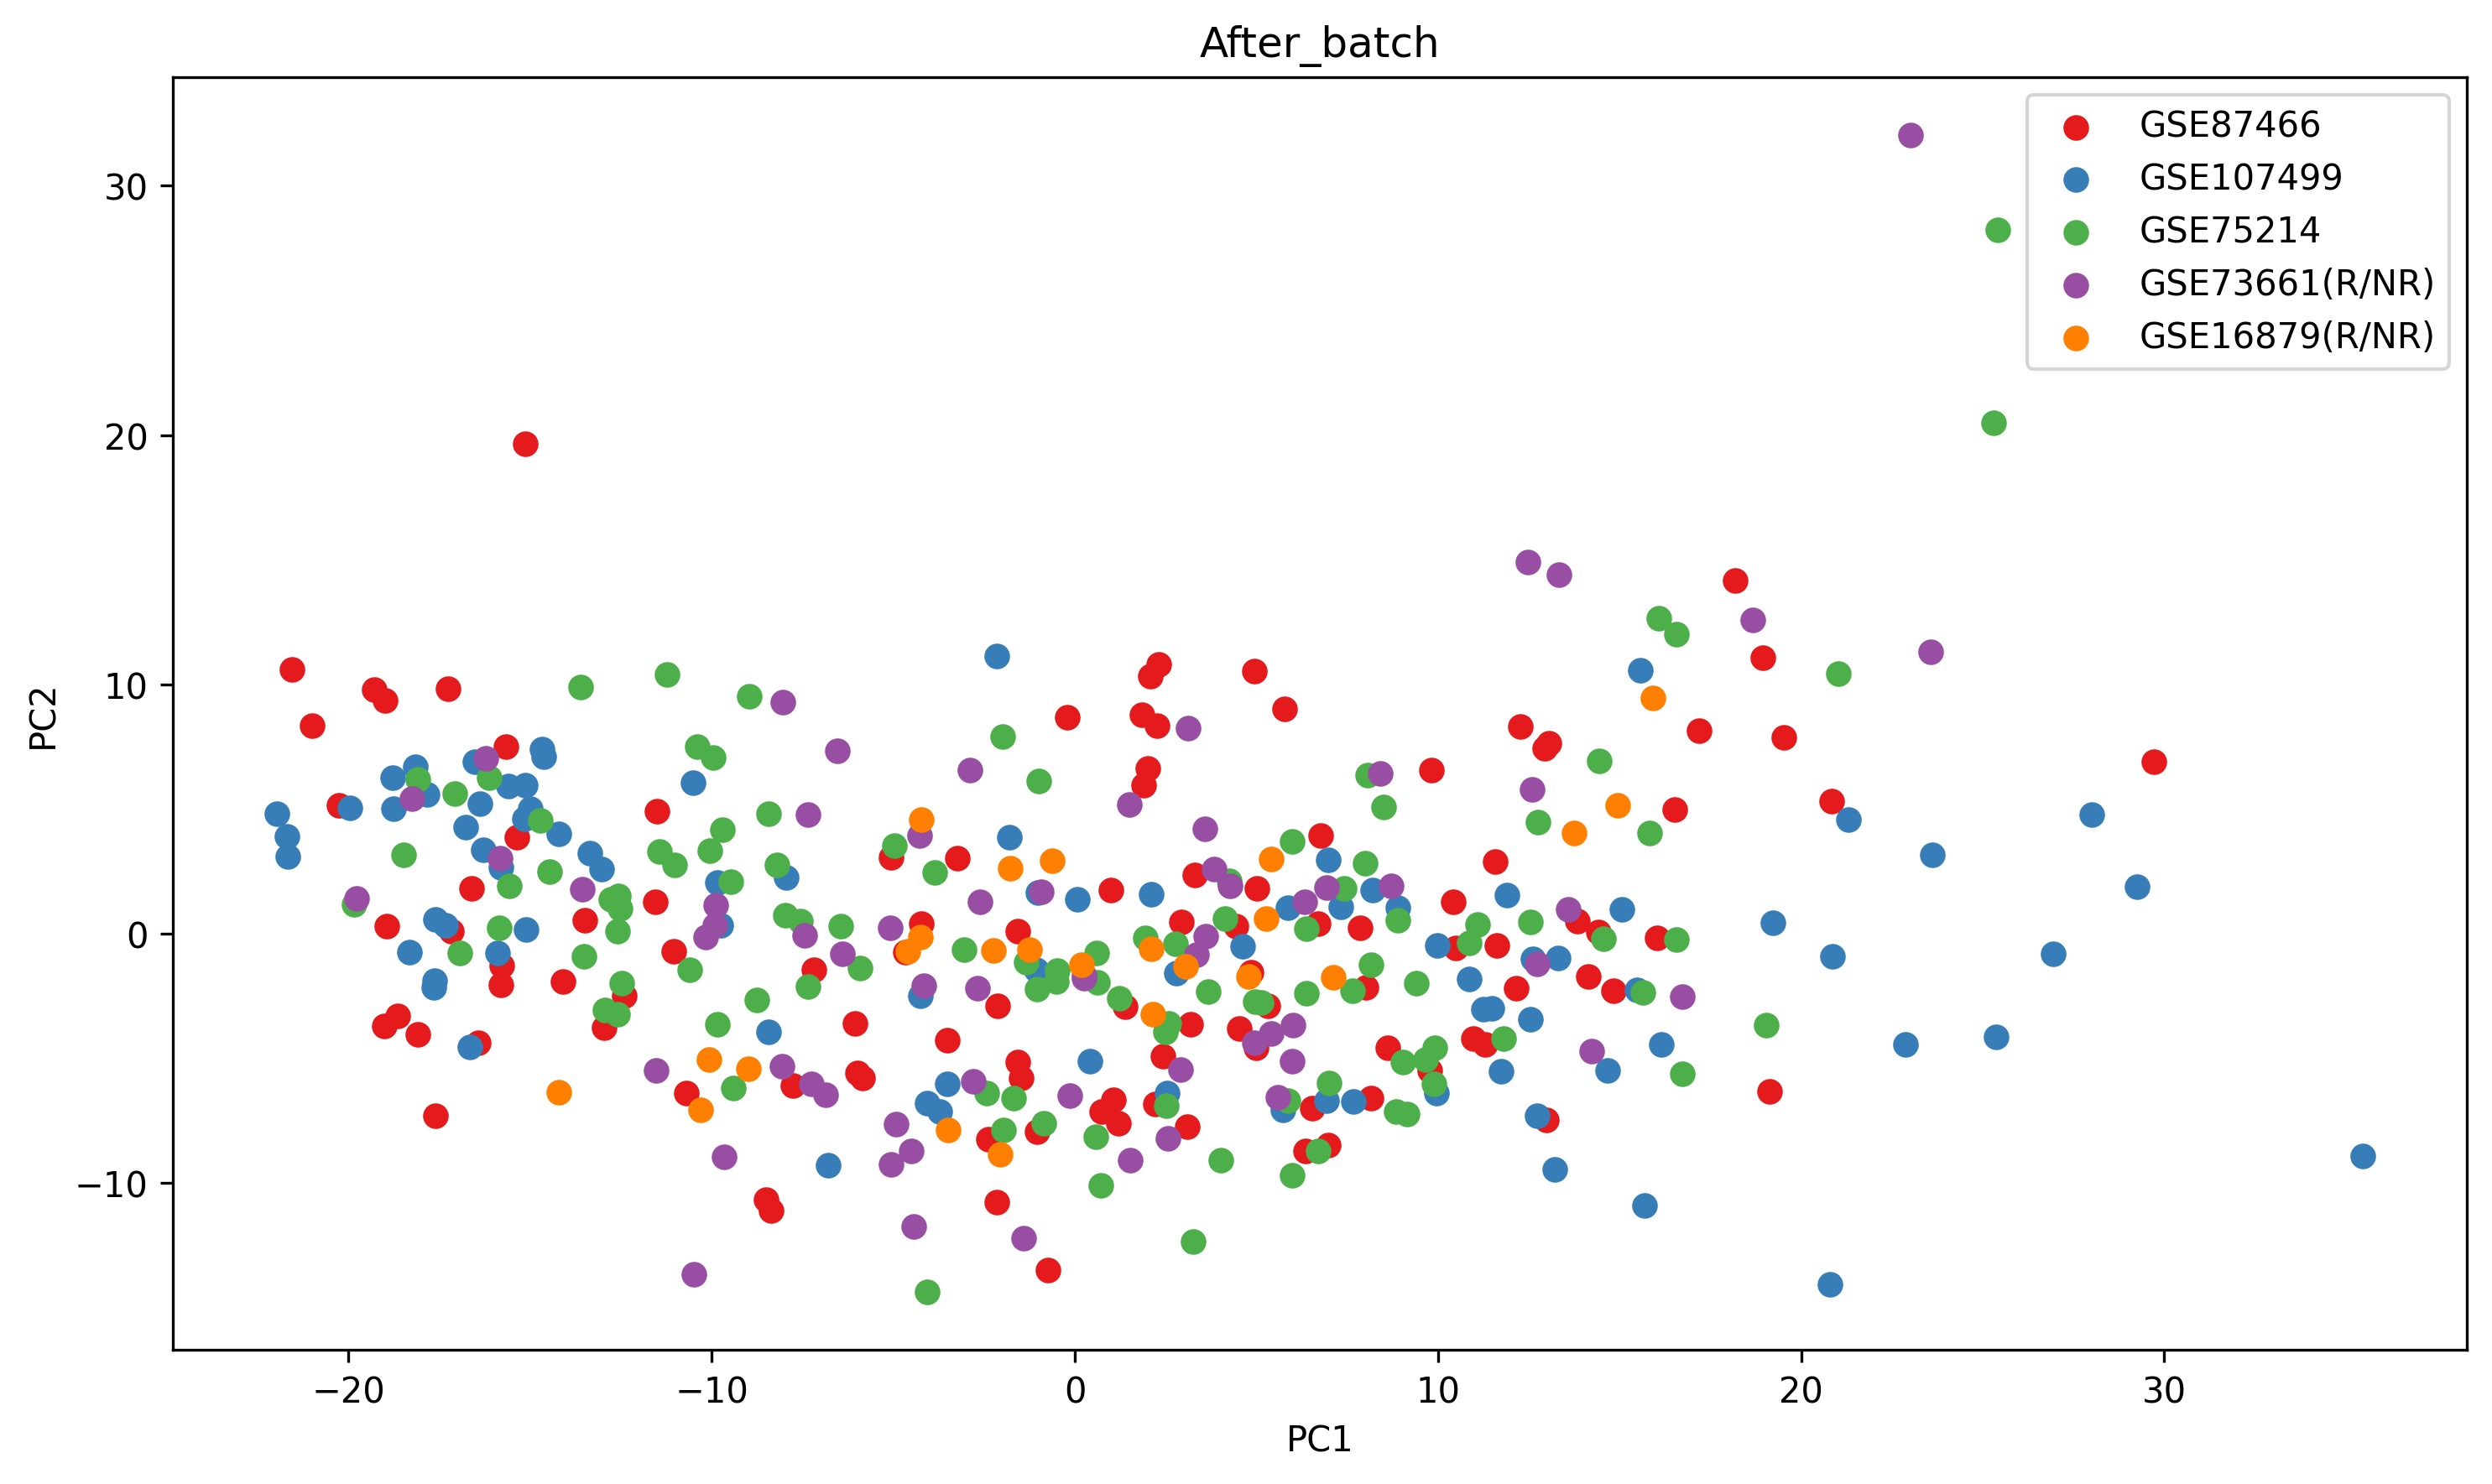

In [12]:
df1 = pd.read_csv("GSE87466.csv", header=0).drop(['label','sublabel'], axis=1)
df2 = pd.read_csv("GSE107499.csv", header=0).drop(['label'], axis=1)
df3 = pd.read_csv("GSE75214.csv", header=0).drop(['label','sublabel'], axis=1)
df4 = pd.read_csv("GSE73661_rightlabel.csv", header=0).drop(['label'], axis=1)
df5 = pd.read_csv("GSE16879.csv", header=0).drop(['label'], axis=1)
df1 = df1.rename(columns={'Unnamed: 0': 'id'}).T
df2 = df2.rename(columns={'Unnamed: 0': 'id'}).T
df3 = df3.rename(columns={'Unnamed: 0': 'id'}).T
df4 = df4.rename(columns={'Unnamed: 0': 'id'}).T
df5 = df5.rename(columns={'Unnamed: 0': 'id'}).T
df1 = df1.rename(columns=df1.iloc[0]).drop(df1.index[0])
df2 = df2.rename(columns=df2.iloc[0]).drop(df2.index[0])
df3 = df3.rename(columns=df3.iloc[0]).drop(df3.index[0])
df4 = df4.rename(columns=df4.iloc[0]).drop(df4.index[0])
df5 = df5.rename(columns=df5.iloc[0]).drop(df5.index[0])
df5 = np.log2(df5.astype(float) + 1)

df_expression = pd.concat([df1,df2,df3,df4,df5],join="inner",axis=1)
batch = []
datasets = [df1,df2,df3,df4,df5]
for j in range(len(datasets)):
    batch.extend([j for _ in range(len(datasets[j].columns))])
    
df_expression = df_expression.apply(pd.to_numeric, errors='coerce')
df_corrected = pycombat(df_expression,batch)

expression_after_batch = df_corrected.T

pca = PCA(n_components=20)
PCA_dat_all = pca.fit_transform(expression_after_batch)

arr = [0] * 108 + [1] * 87 + [2] * 108 + [3] * 64 + [4] * 24
color_mapping = color_mapping = {
    0: '#E41A1C',  
    1: '#377EB8',  
    2: '#4DAF4A',  
    3: '#984EA3', 
    4: '#FF7F00'  
}
colors = [color_mapping[label] for label in arr]
unique_labels = np.array(list(set(arr)))
legend_labels = ['GSE87466', 'GSE107499', 'GSE75214', 'GSE73661(R/NR)', 'GSE16879(R/NR)']

plt.figure(figsize=(10, 6), dpi=300)
for i, label in enumerate(unique_labels):
    plt.scatter(PCA_dat_all[arr == label, 0],
                -PCA_dat_all[arr == label, 1],
                s=40,
                color=color_mapping[label],
                label=legend_labels[i])


plt.legend(loc='best')
plt.title('After_batch')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

In [13]:
medications = [
    "IFX", "IFX", "VDZ", "IFX", "IFX", "IFX", "IFX", "VDZ", "IFX", "IFX",
    "IFX", "IFX", "VDZ", "VDZ", "IFX", "VDZ", "VDZ", "IFX", "VDZ", "VDZ",
    "IFX", "VDZ", "IFX", "VDZ", "IFX", "VDZ", "IFX", "IFX", "VDZ", "IFX",
    "VDZ", "IFX", "VDZ", "VDZ", "IFX", "VDZ", "IFX", "VDZ", "IFX", "IFX",
    "VDZ", "IFX", "IFX", "VDZ", "IFX", "VDZ", "IFX", "IFX", "IFX", "IFX",
    "VDZ", "IFX", "VDZ", "VDZ", "VDZ", "VDZ", "VDZ", "VDZ", "VDZ", "IFX",
    "VDZ", "VDZ", "VDZ", "VDZ", "VDZ", "IFX", "VDZ", "VDZ", "IFX", "IFX",
    "IFX", "IFX", "VDZ", "IFX", "IFX", "IFX", "IFX", "IFX", "IFX", "IFX",
    "VDZ", "VDZ", "IFX", "IFX", "VDZ", "IFX", "VDZ", "VDZ",
]

patientindex = [
    "GSM364651", "GSM364652", "GSM1900233", "GSM1900155", "GSM364641",
    "GSM1900176", "GSM1900154", "GSM1900248", "GSM1900148", "GSM1900206",
    "GSM364649", "GSM364646", "GSM1900297", "GSM1900315", "GSM364643",
    "GSM1900285", "GSM1900320", "GSM1900195", "GSM1900274", "GSM1900251",
    "GSM364656", "GSM1900324", "GSM1900185", "GSM1900294", "GSM364653",
    "GSM1900283", "GSM364650", "GSM364654", "GSM1900257", "GSM364644",
    "GSM1900244", "GSM364642", "GSM1900310", "GSM1900263", "GSM1900184",
    "GSM1900241", "GSM1900214", "GSM1900316", "GSM1900217", "GSM1900175",
    "GSM1900323", "GSM1900215", "GSM364648", "GSM1900318", "GSM364647",
    "GSM1900230", "GSM1900202", "GSM364645", "GSM1900208", "GSM364655",
    "GSM1900291", "GSM1900181", "GSM1900319", "GSM1900288", "GSM1900307",
    "GSM1900322", "GSM1900321", "GSM1900227", "GSM1900314", "GSM364638",
    "GSM1900277", "GSM1900325", "GSM1900271", "GSM1900299", "GSM1900317",
    "GSM364639", "GSM1900265", "GSM1900280", "GSM1900210", "GSM1900213",
    "GSM1900192", "GSM364634", "GSM1900302", "GSM1900180", "GSM1900158",
    "GSM1900204", "GSM364640", "GSM364636", "GSM1900172", "GSM1900186",
    "GSM1900260", "GSM1900236", "GSM364635", "GSM364637", "GSM1900313",
    "GSM364633", "GSM1900268", "GSM1900305",
]


In [ ]:
label_data = expression_after_batch.tail(88)
label_data['label'] = pd.read_csv("GSE73661_rightlabel.csv", header=0)['label'].tolist() + pd.read_csv("GSE16879.csv", header=0)['label'].tolist()
label_data['medication'] = label_data.index.map(dict(zip(patientindex, medications)))
label_data = label_data[label_data['medication'] == 'IFX']
label_data = label_data.transpose()

front_columns = label_data.loc[:, label_data.loc['label'] == 0]
back_columns = label_data.loc[:, label_data.loc['label'] == 1]
selected_data = pd.concat([front_columns, back_columns], axis=1)
selected_data = selected_data.iloc[:-2]

expr = selected_data
expr = expr.astype(float)

In [17]:
pandas2ri.activate()
NR_R = ['a']*31+ ['b']*16
group =  robjects.FactorVector(NR_R)
design_formula = Formula('~ group')
design_formula.environment['group'] = group
design = stats.model_matrix(design_formula)
fit = limma.lmFit(pandas2ri.DataFrame(expr), design)
fit = limma.eBayes(fit)
deg_limma = limma.topTable(fit, coef = 2, number = 40000)

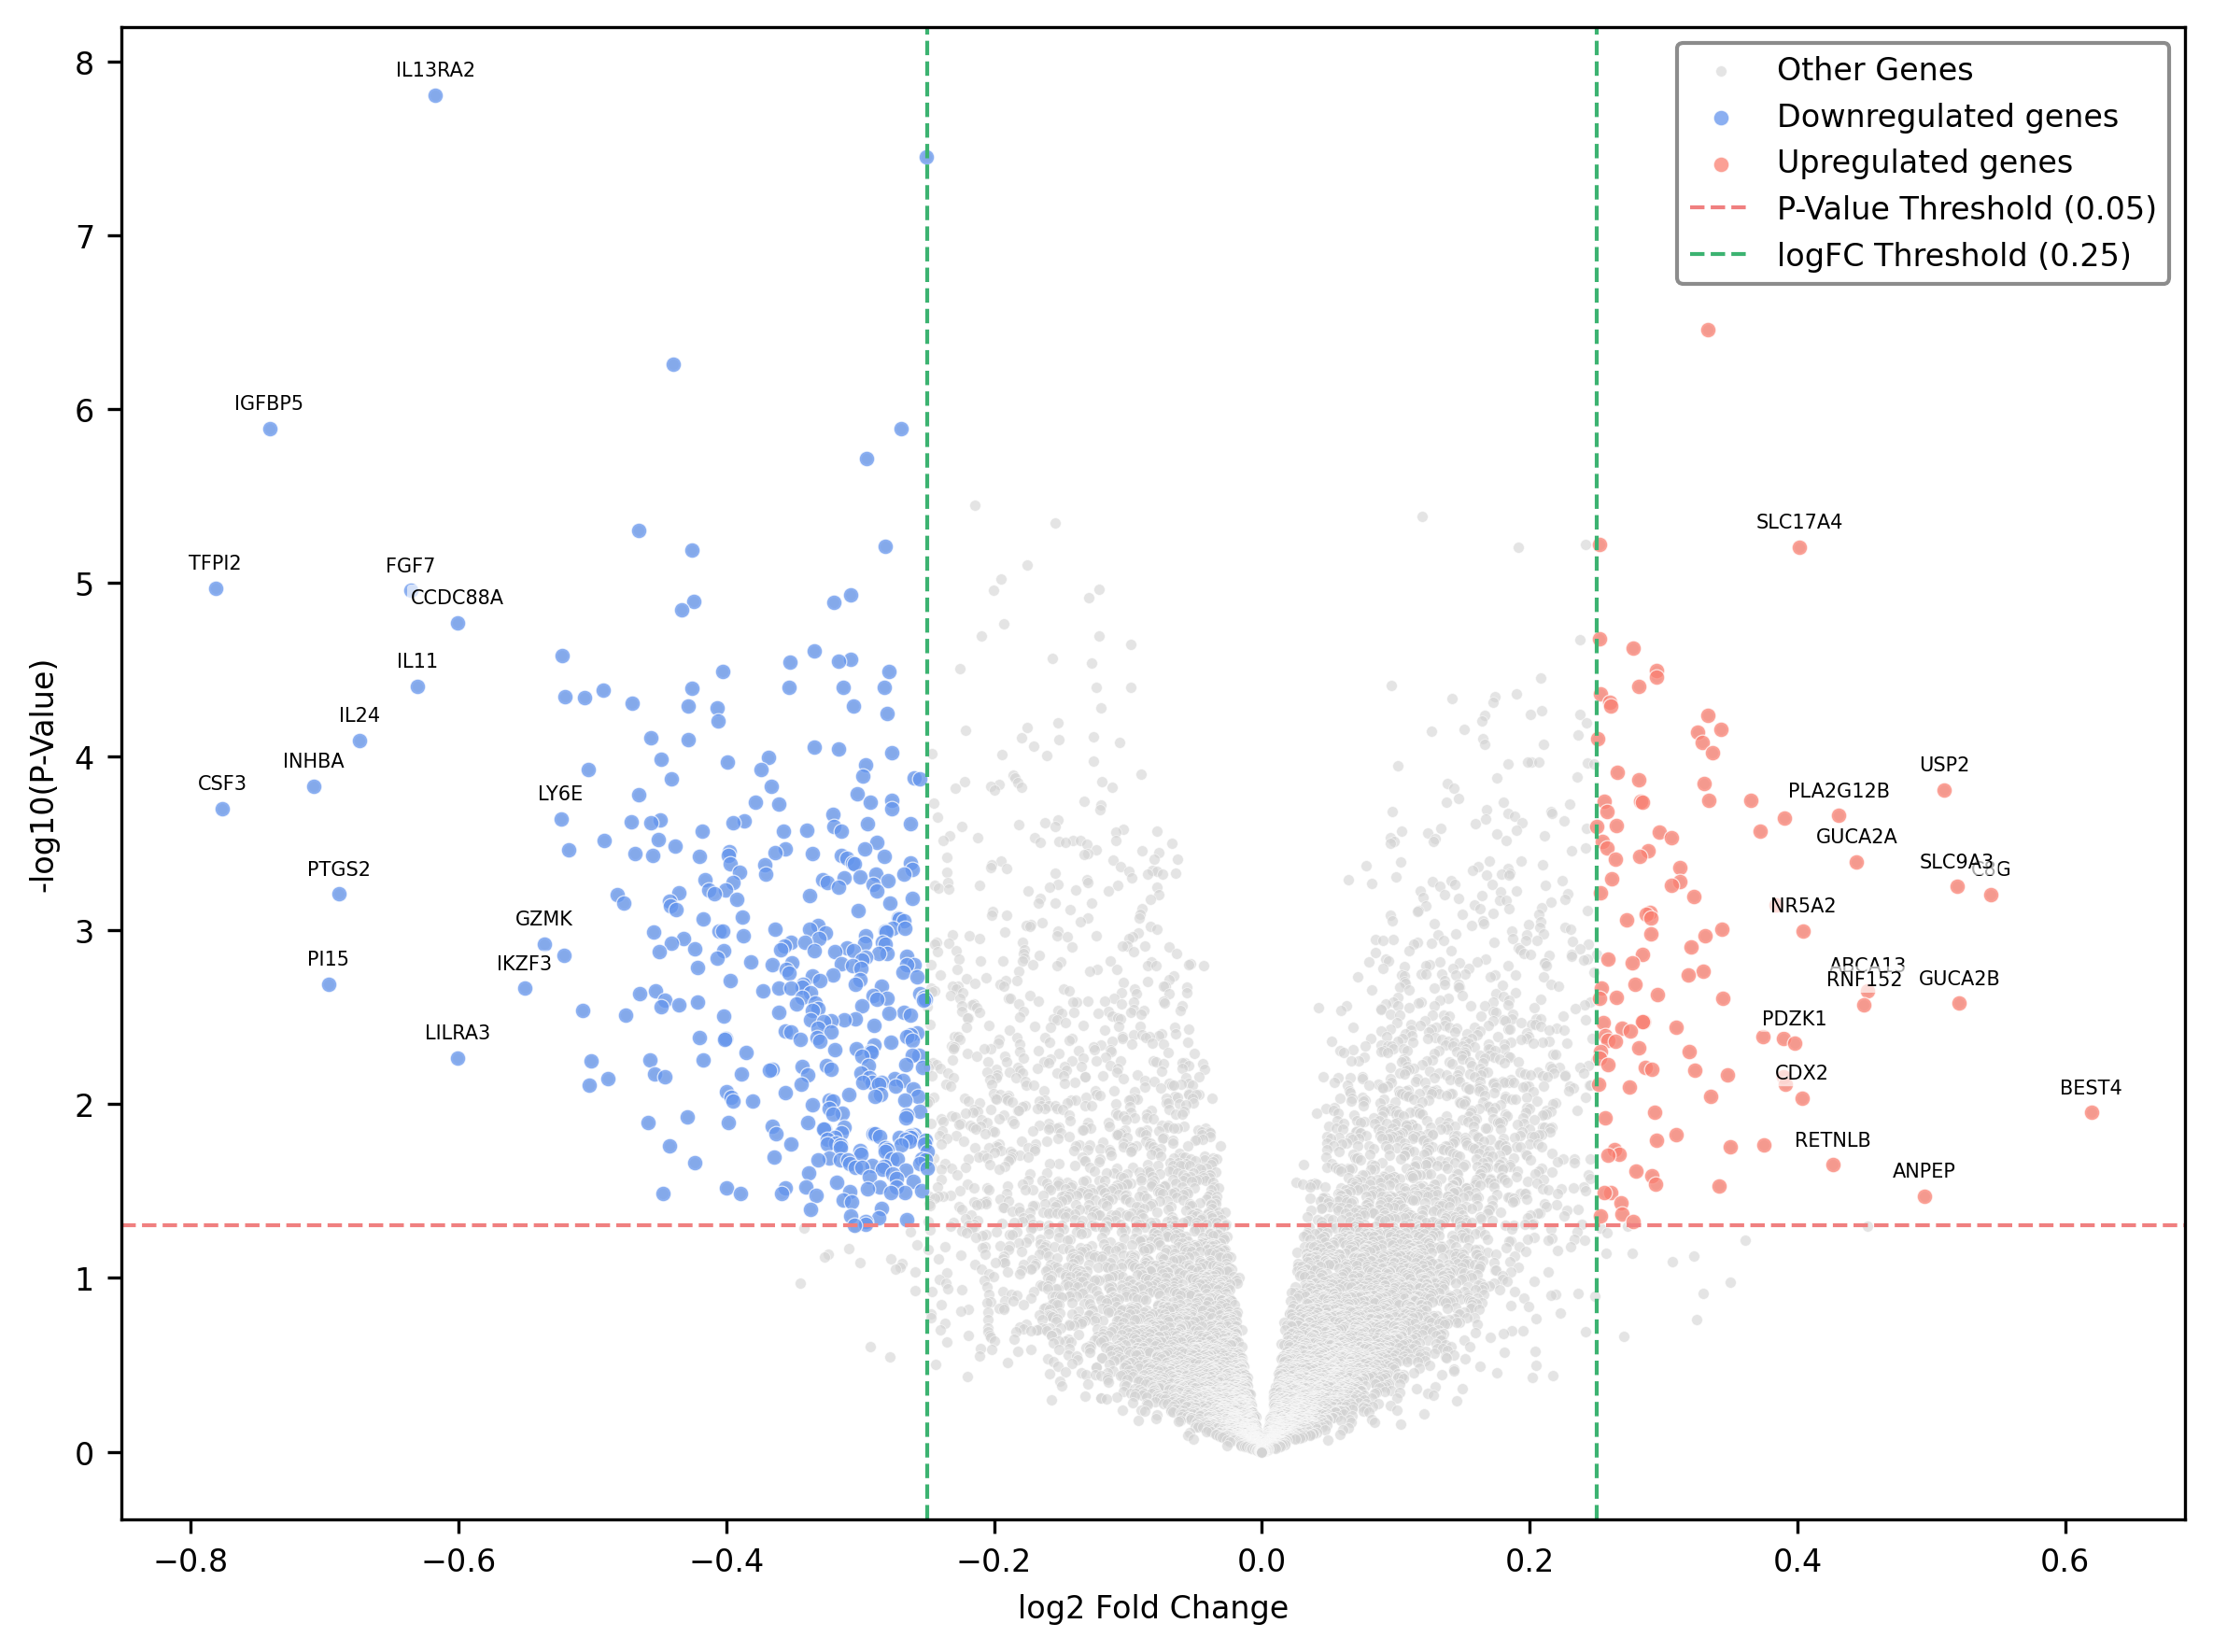

In [20]:
p_threshold = 0.05
logFC_cutoff   = 0.25
top_each_side  = 15
figsize        = (8, 6)
dpi            = 300

alldiff = deg_limma.rename(columns={'P.Value': 'PValue', 'adj.P.Val': 'adjPValue'})
volcano_data = alldiff[['logFC', 'PValue', 'adjPValue']].rename(columns={'adjPValue': 'FDR'})
diff = alldiff.query('(PValue < @p_threshold) & (abs(logFC) > @logFC_cutoff)')
selected_row_names = diff.index.tolist()  
up = diff.query('logFC >  @logFC_cutoff')
down = diff.query('logFC < -@logFC_cutoff')
annot_idx = down['logFC'].nsmallest(top_each_side).index.union(
    up['logFC'].nlargest(top_each_side).index
)

plt.figure(figsize=figsize, dpi=dpi)

plt.scatter(
    volcano_data['logFC'], -np.log10(volcano_data['PValue']),
    s=8, color='lightgray', alpha=0.6, edgecolors='white', linewidths=0.2,
    label='Other Genes', zorder=1
)

plt.scatter(
    down['logFC'], -np.log10(down['PValue']),
    s=16, color='cornflowerblue', alpha=0.75, edgecolors='white', linewidths=0.3,
    label='Downregulated genes', zorder=2
)

plt.scatter(
    up['logFC'], -np.log10(up['PValue']),
    s=16, color='salmon', alpha=0.75, edgecolors='white', linewidths=0.3,
    label='Upregulated genes', zorder=2
)

for g, row in diff.loc[annot_idx].iterrows():
    plt.annotate(
    g,
    (row['logFC'], -np.log10(row['PValue'])),
    textcoords="offset points",
    xytext=(0, 4),          
    ha='center',            
    va='bottom',            
    fontsize=5,
    color='black',
    bbox=dict(
        boxstyle="round,pad=0.2",
        fc="white",
        ec="none",
        alpha=0.65
    )
)

plt.axhline(y=-np.log10(p_threshold), color='lightcoral', linestyle='--', linewidth=1.0,
            label=f'P-Value Threshold ({p_threshold})')
plt.axvline(x= logFC_cutoff,  color='mediumseagreen', linestyle='--', linewidth=1.0,
            label=f'logFC Threshold ({logFC_cutoff})')
plt.axvline(x=-logFC_cutoff, color='mediumseagreen', linestyle='--', linewidth=1.0)

plt.xlabel('log2 Fold Change', fontsize=8)
plt.ylabel('-log10(P-Value)', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.legend(loc="upper right", fontsize=8, frameon=True, framealpha=0.9, edgecolor='gray')

plt.tight_layout()
plt.show()

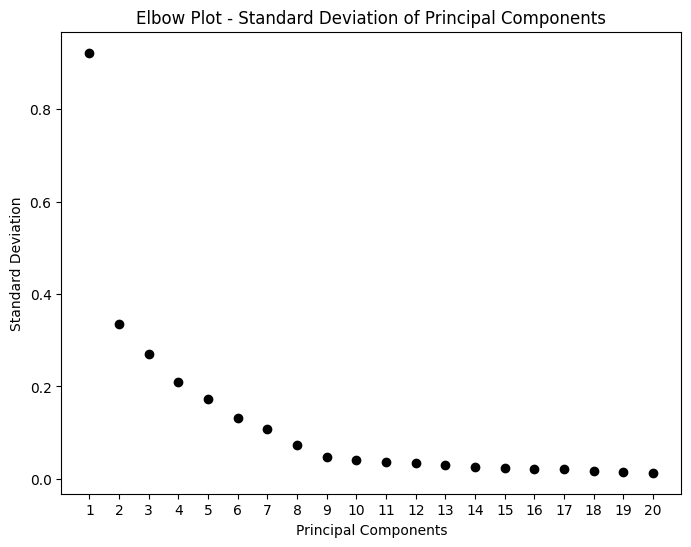

Principal Component 1 Standard Deviation: 0.9220302700996399
Principal Component 2 Standard Deviation: 0.3345296382904053
Principal Component 3 Standard Deviation: 0.270406037569046
Principal Component 4 Standard Deviation: 0.20935572683811188
Principal Component 5 Standard Deviation: 0.1732695996761322
Principal Component 6 Standard Deviation: 0.13087433576583862
Principal Component 7 Standard Deviation: 0.10854069888591766
Principal Component 8 Standard Deviation: 0.07395633310079575
Principal Component 9 Standard Deviation: 0.04649670049548149
Principal Component 10 Standard Deviation: 0.041047047823667526
Principal Component 11 Standard Deviation: 0.037500761449337006
Principal Component 12 Standard Deviation: 0.03369792178273201
Principal Component 13 Standard Deviation: 0.030078012496232986
Principal Component 14 Standard Deviation: 0.026249896734952927
Principal Component 15 Standard Deviation: 0.023053564131259918
Principal Component 16 Standard Deviation: 0.022098800167441368


In [23]:
batch = pd.read_csv("UC_after_batch.csv", header=0)['Unnamed: 0'].tolist()
sample = batch + expr.columns.to_list()
expression_after_batch_filtered = expression_after_batch.loc[sample]
expression_after_batch_filtered = expression_after_batch_filtered.loc[:, selected_row_names]
all_labels = [0] * 31 + [1] * 16

model = xgboost.XGBClassifier(alpha =1,eta = 0.1).fit(expression_after_batch_filtered.tail(47), all_labels)
explainer = shap.Explainer(model)
shap_values1 = explainer(expression_after_batch_filtered.head(208))
shap_values2 = explainer(expression_after_batch_filtered.tail(47))
shap_values_values = np.concatenate([shap_values1.values, shap_values2.values], axis=0)

num_components = 20
pca = PCA(n_components=num_components)
pca.fit(shap_values2.values)
pca_components2 = pca.transform(shap_values2.values)
std_deviation = np.std(pca_components2, axis=0)
num_components = len(std_deviation)

std_deviation = np.std(pca_components2, axis=0)
num_components = len(std_deviation)

plt.figure(figsize=(8, 6))
plt.scatter(range(1, num_components + 1), std_deviation, color='black', marker='o')
plt.title('Elbow Plot - Standard Deviation of Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Standard Deviation')
plt.xticks(np.arange(1, num_components + 1))
plt.show()
for i, std in enumerate(std_deviation):
    print(f"Principal Component {i+1} Standard Deviation: {std}")

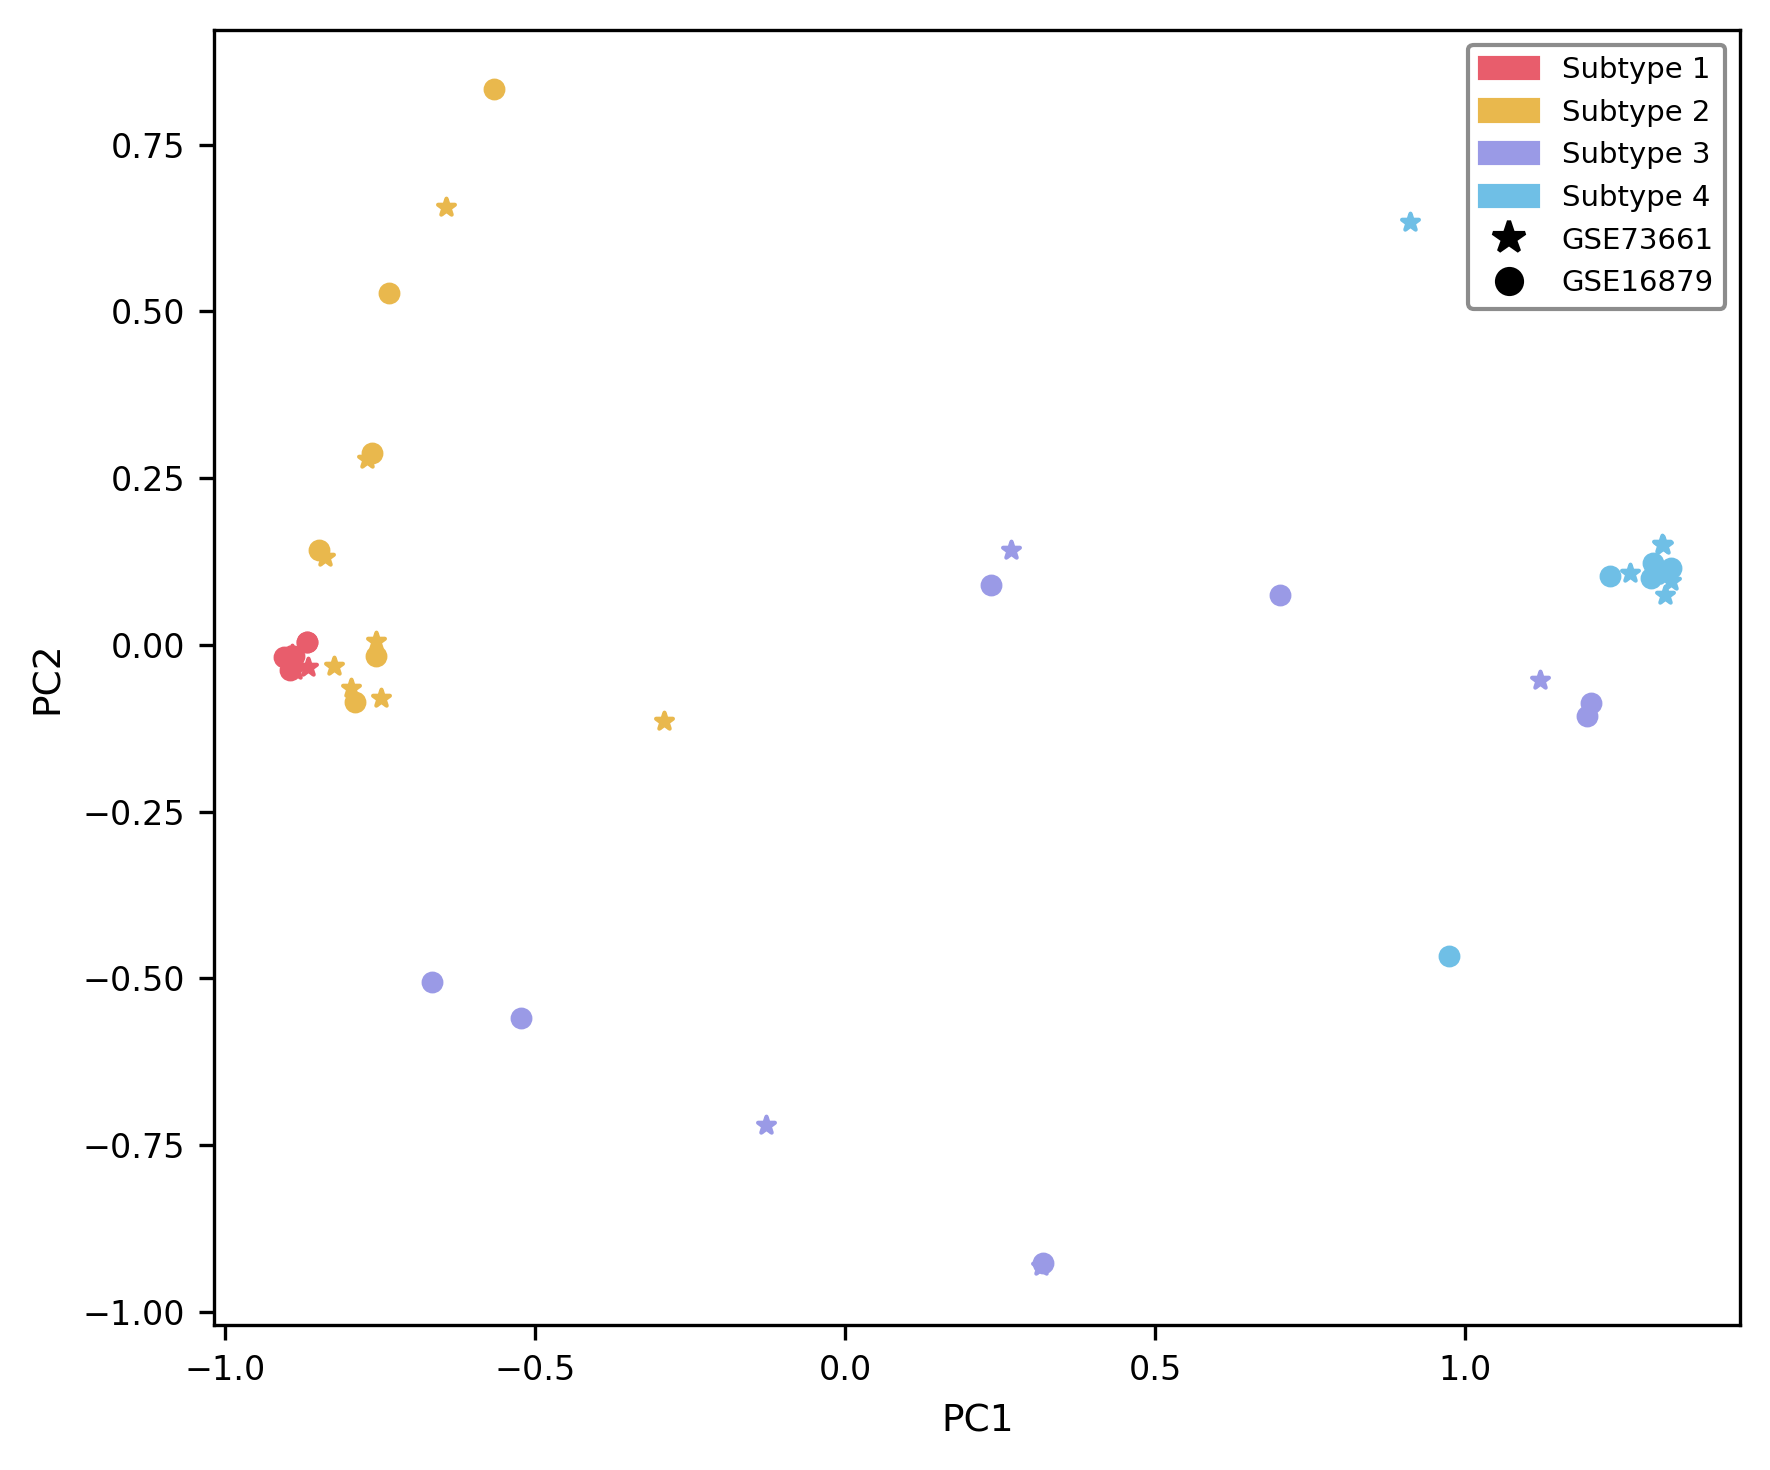

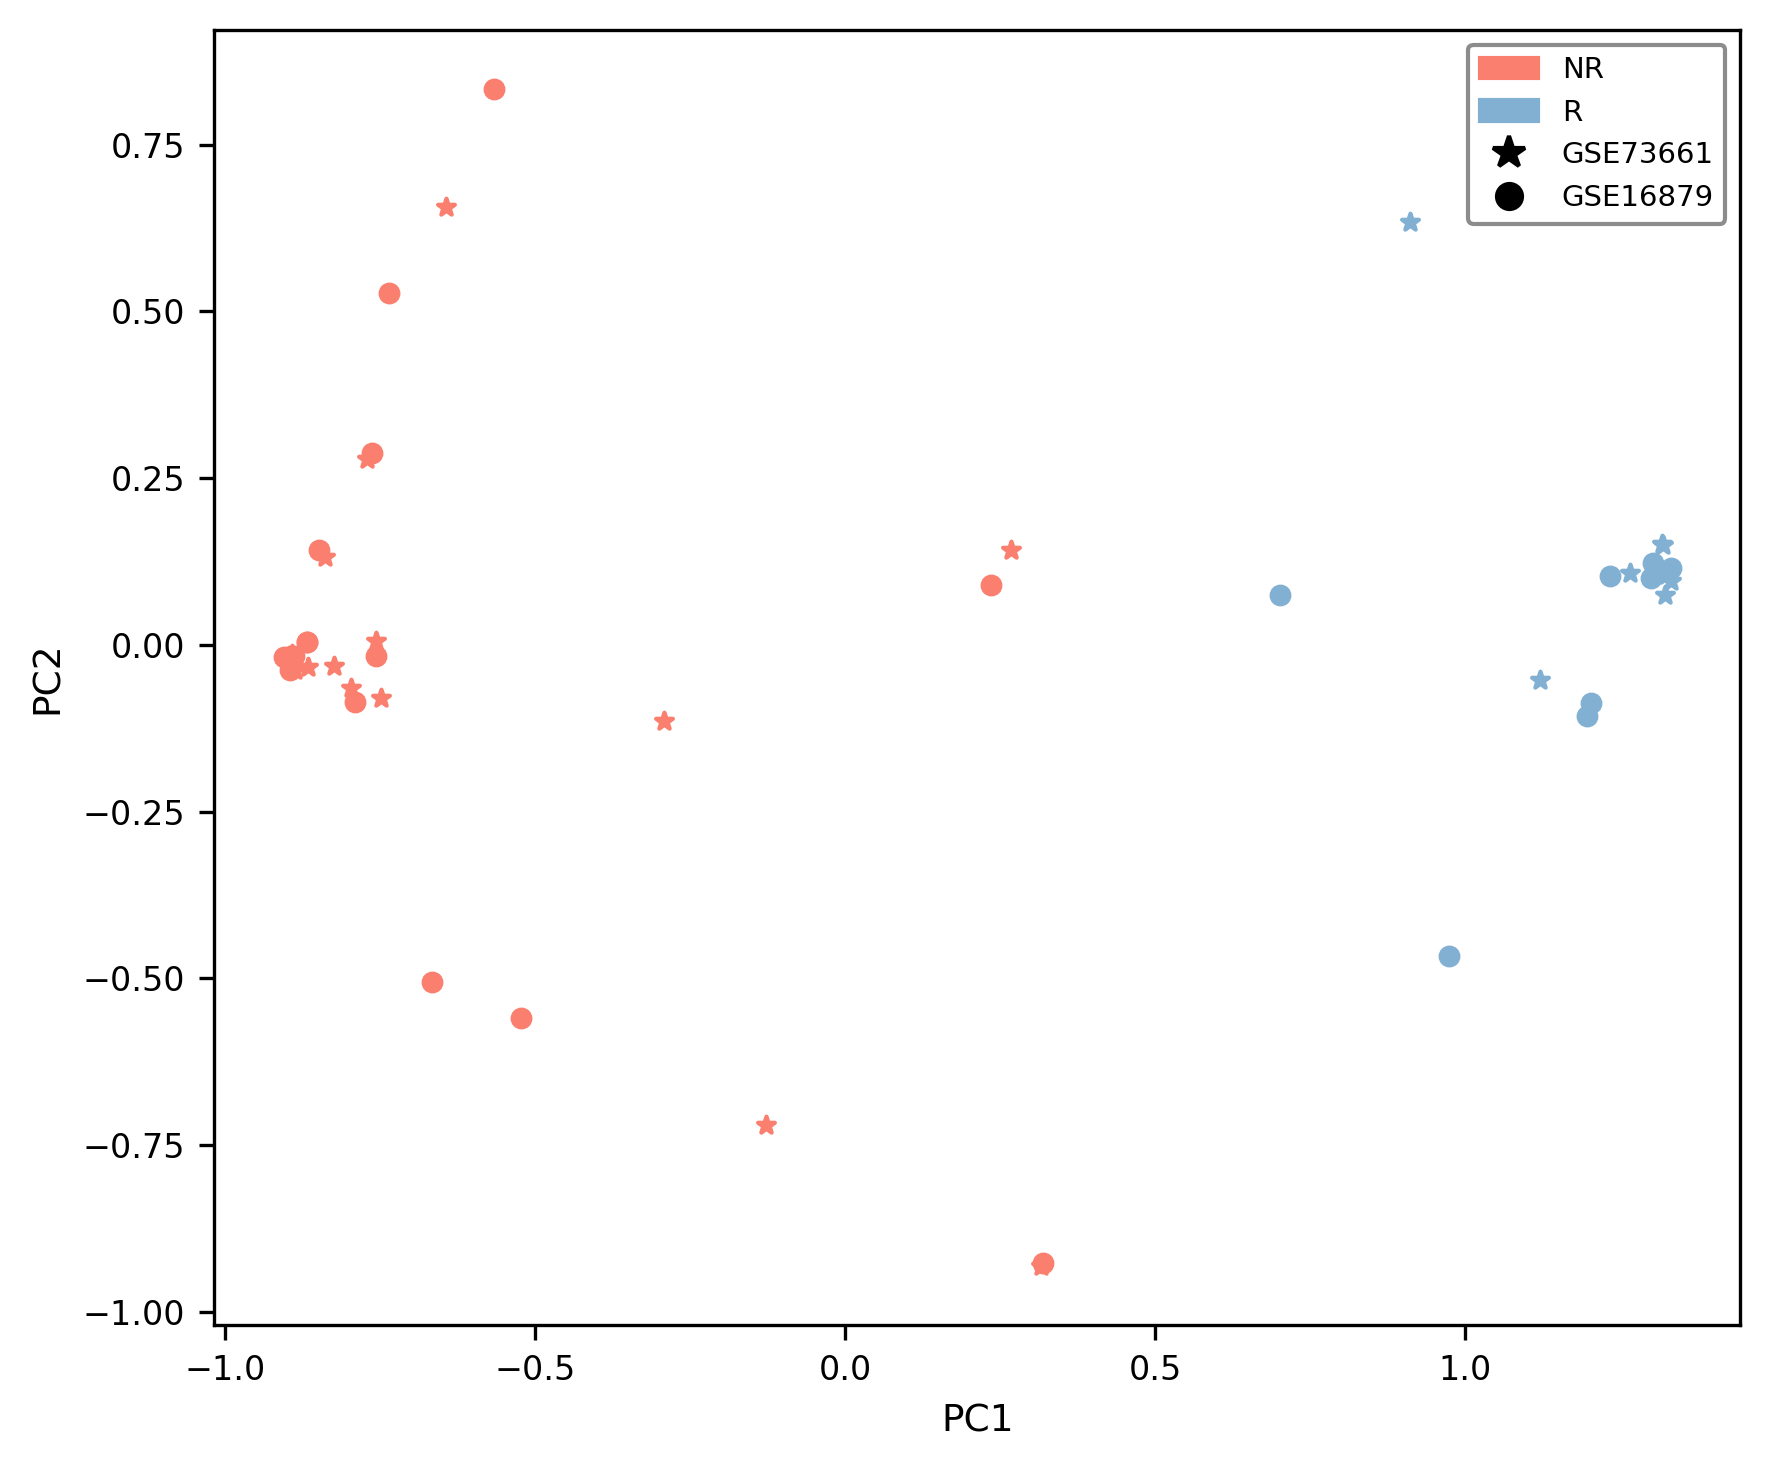

In [28]:
def SC_nSNN(A, k, sigma):
    """
    A: (n_samples, n_features)
    k: k-nearest neighbors
    sigma: Gaussian kernel bandwidth
    """
    n = A.shape[0]
    B = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            val = np.exp(-np.sum((A[i] - A[j]) ** 2) / (2 * sigma ** 2))
            B[i, j] = B[j, i] = val

    I = np.argsort(-B, axis=1)
    E = np.zeros((n, n))
    for i in range(n):
        E[i, I[i, :k]] = 1

    W = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            diff = np.sum(np.abs(E[i] - E[j])) / 2
            W[i, j] = W[j, i] = (k - diff + int(E[i, j] and E[j, i])) / k
    return W


def spectral_clustering(S, num_clusters):
    d = np.sum(S, axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d + 1e-8))
    L = D_inv_sqrt @ (np.diag(d) - S) @ D_inv_sqrt

    eigvals, eigvecs = np.linalg.eig(L)

    idx = np.argsort(eigvals)[:num_clusters]
    X = eigvecs[:, idx]
    X = np.real(X)

    km = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    return labels



nn = 5
num_clusters = 4
simi = SC_nSNN(pca_components2[:, :4], nn, sigma=1.5)
clusters = spectral_clustering(simi, num_clusters)

clusters_step1 = clusters.copy()
clusters_step1 = np.where(clusters_step1 == 1, 100, clusters_step1)  
clusters_step1 = np.where(clusters_step1 == 2, 1, clusters_step1)    
clusters_step1 = np.where(clusters_step1 == 100, 2, clusters_step1)  
clusters_final = clusters_step1.copy()
clusters_final = np.where(clusters_final == 2, 200, clusters_final)  
clusters_final = np.where(clusters_final == 3, 2, clusters_final)    
clusters_final = np.where(clusters_final == 200, 3, clusters_final)  
clusters = clusters_final  

cluster_colors = {
    0: "#E85D6C",
    1: "#E9B84D",
    2: "#9A9AE6",
    3: "#6FBFE6"
}
color_all = [cluster_colors[c] for c in clusters]
cluster_response = ["#FA7F6F" if x == 0 else "#82B0D2" for x in all_labels]
markers = ['*'] * 15 + ['o'] * 16 + ['*'] * 8 + ['o'] * 8


def plot_scatter(colors, title=None, extra_handles=None):
    plt.figure(figsize=(6, 5), dpi=300)

    for i in range(len(pca_components2)):
        plt.scatter(
            pca_components2[i, 0],
            pca_components2[i, 1],
            color=colors[i],
            marker=markers[i],
            s=18
        )

    if title is not None:
        plt.title(title, fontsize=10)

    plt.xlabel("PC1", fontsize=9)
    plt.ylabel("PC2", fontsize=9)
    plt.tick_params(labelsize=8)

    if extra_handles is not None:
        plt.legend(
            handles=extra_handles,
            fontsize=7,          
            frameon=True,
            framealpha=0.9,
            edgecolor="gray",
            loc="upper right"    
        )

    plt.tight_layout()
    plt.show()


cluster_handles = [
    mpatches.Patch(color=cluster_colors[c], label=f'Subtype {c+1}')
    for c in cluster_colors
]

dataset_handles = [
    plt.Line2D([0], [0], marker='*', color='w',
               markerfacecolor='k', markeredgecolor='k',
               markersize=8, linestyle='None', label='GSE73661'),
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor='k', markeredgecolor='k',
               markersize=6, linestyle='None', label='GSE16879')
]

response_handles = [
    mpatches.Patch(color='#FA7F6F', label='NR'),
    mpatches.Patch(color='#82B0D2', label='R')
]

plot_scatter(
    color_all,
    title=None,
    extra_handles=cluster_handles + dataset_handles
)

plot_scatter(
    cluster_response,
    title=None,
    extra_handles=response_handles + dataset_handles
)


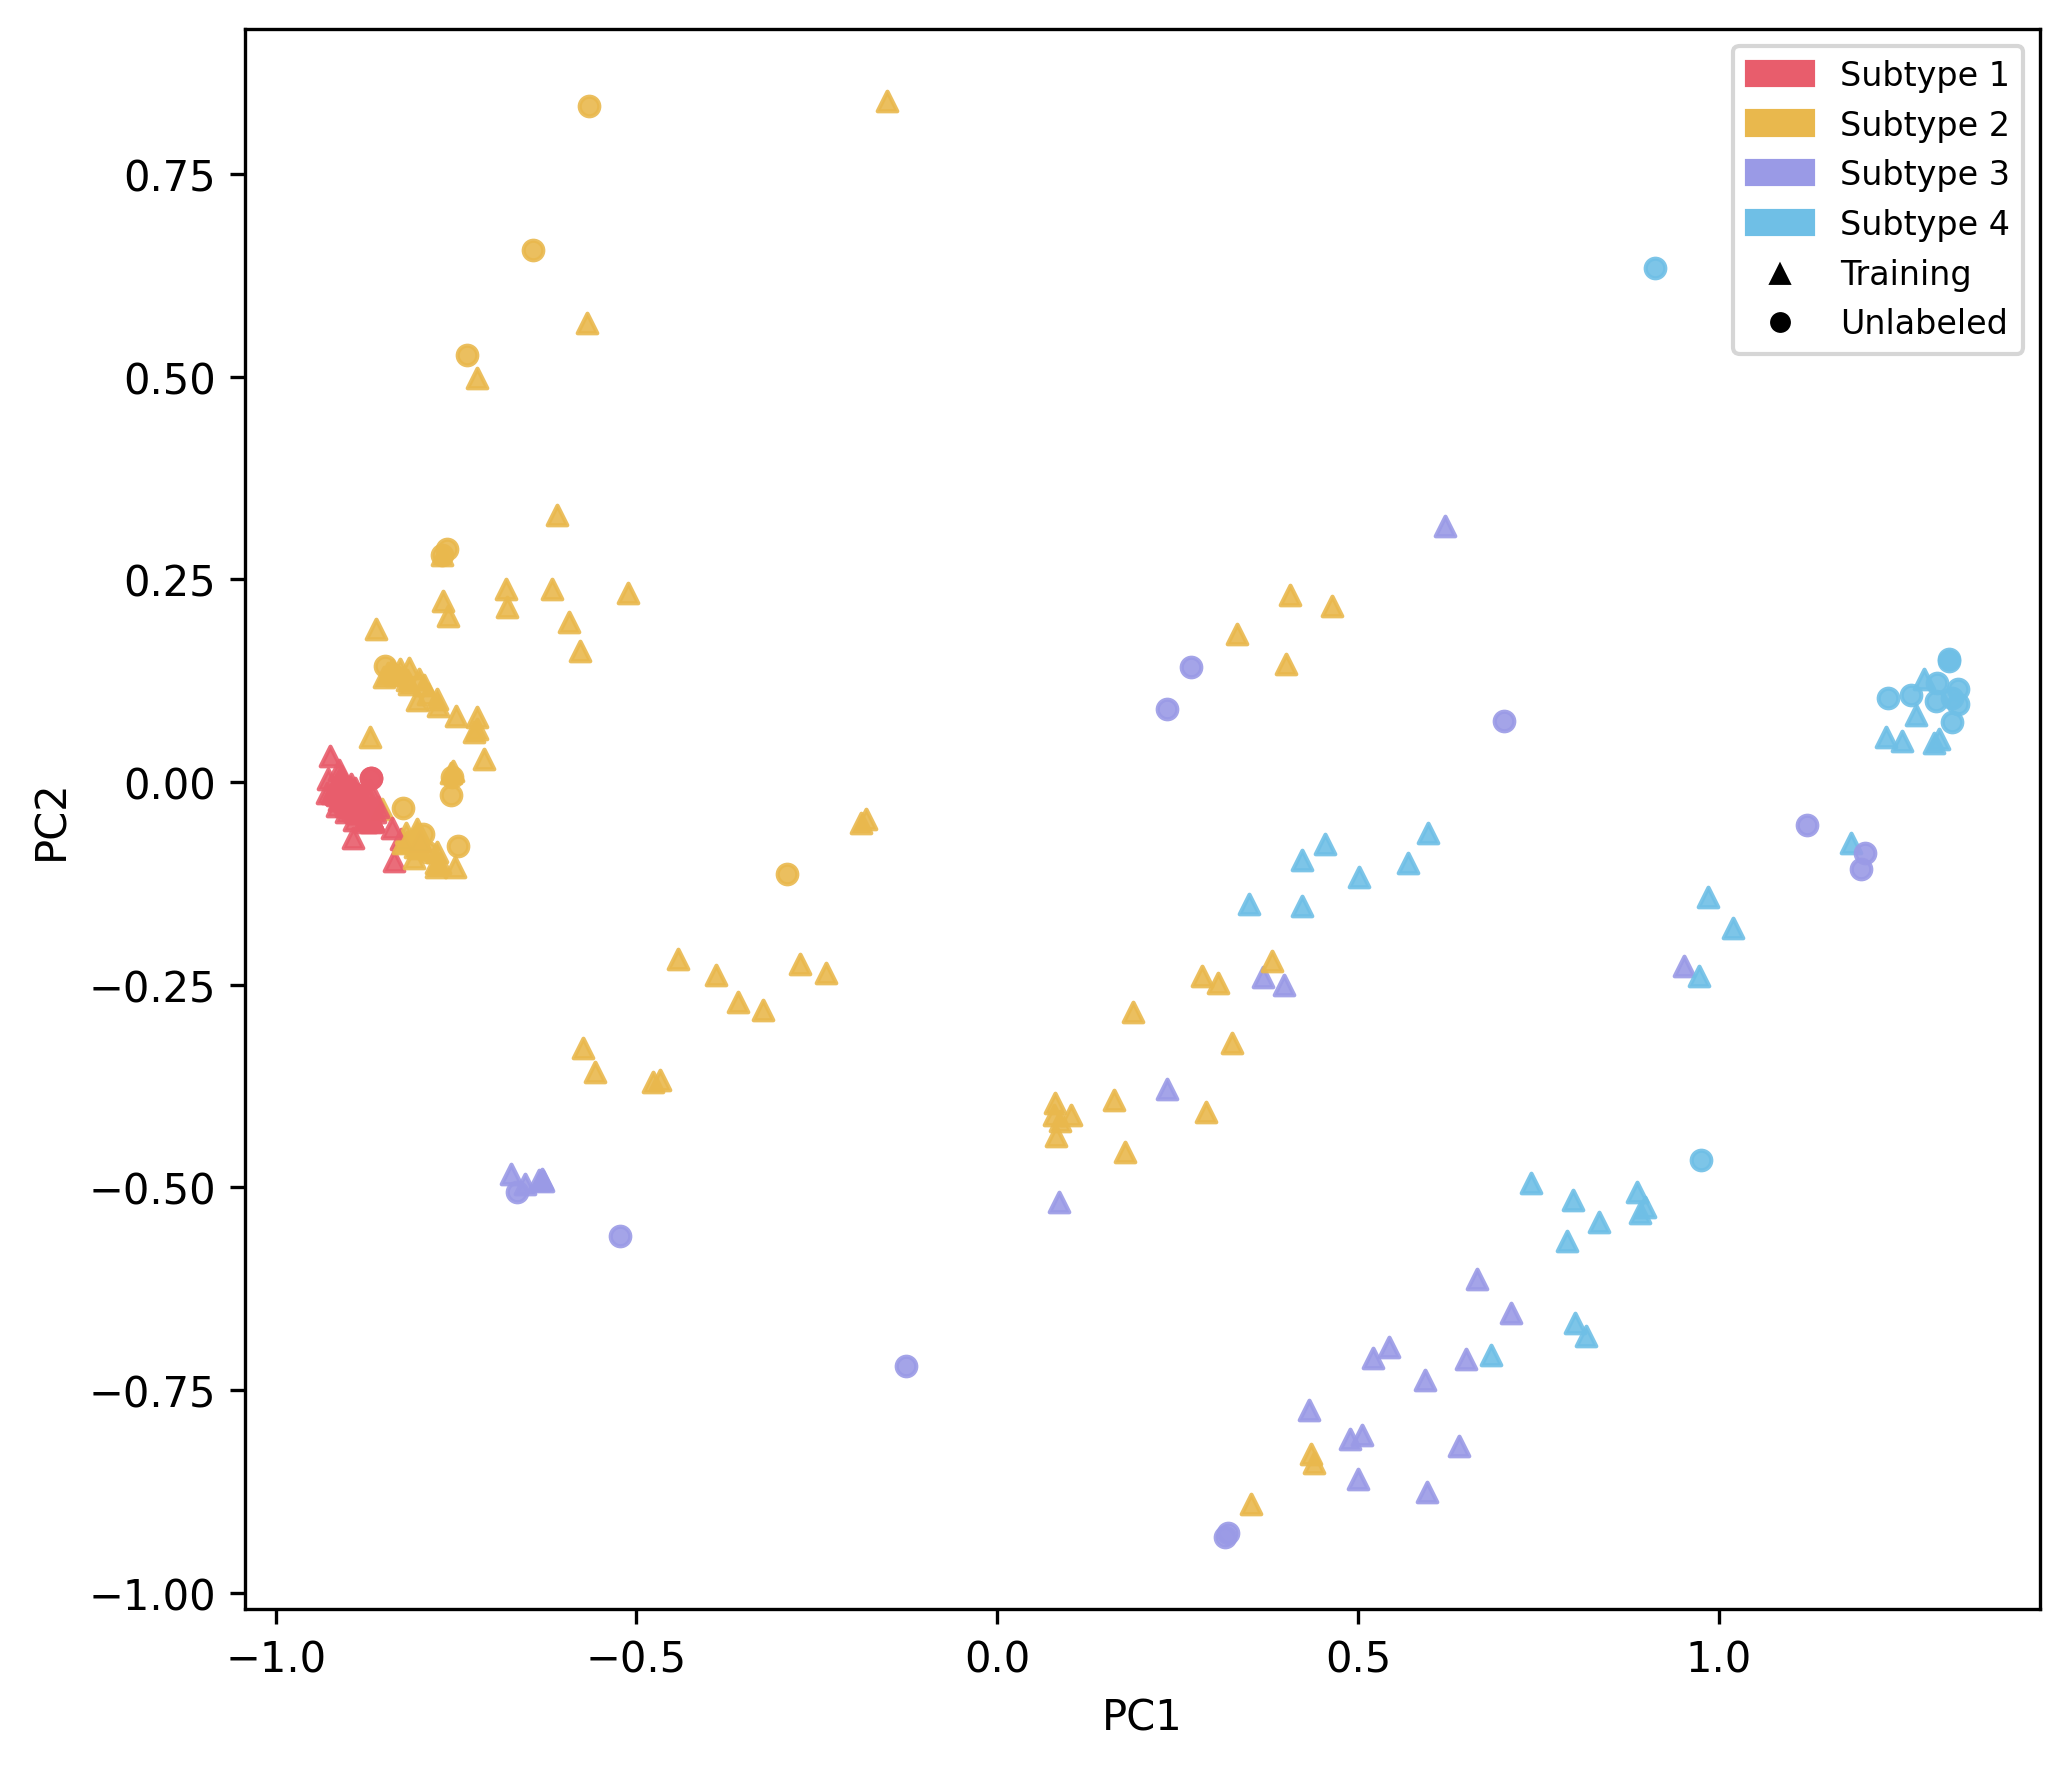

In [31]:
cluster_weight_dict = {
    0: 1,     
    1: 8,      
    2: 2,     
    3: 8     
}

def calculate_distance_weighted(shap_values1, shap_values2, clusters_train, K):
    n_test  = shap_values1.shape[0]
    n_train = shap_values2.shape[0]

    distances = np.zeros((n_test, n_train))
    for i in range(n_test):
        for j in range(n_train):
            distances[i, j] = np.linalg.norm(shap_values1[i, :] - shap_values2[j, :])

    sorted_indices = np.argsort(distances, axis=1)[:, :K]

    n_clusters = len(np.unique(clusters_train))
    weighted_votes = np.zeros((n_test, n_clusters))

    for i in range(n_test):
        for j in sorted_indices[i]:
            c = clusters_train[j]
            w = cluster_weight_dict[c]    
            weighted_votes[i, c] += w

    predictions = np.argmax(weighted_votes, axis=1)
    return predictions, weighted_votes

K = 5
predicted_clusters_test, votes = calculate_distance_weighted(
    shap_values1.values, shap_values2.values, clusters, K
)


COLOR_MAP = {
0: "#E85D6C",
1: "#E9B84D",
2: "#9A9AE6",
3: "#6FBFE6"
}

def color_from_cluster(c):
    return COLOR_MAP.get(int(c), "red")


colors_test  = [color_from_cluster(c) for c in predicted_clusters_test]
colors_train = [color_from_cluster(c) for c in clusters]


pca = PCA(n_components=20)
pca.fit(shap_values2.values)

X_train = pca.transform(shap_values2.values)
X_test  = pca.transform(shap_values1.values)

X_all      = np.vstack([X_test, X_train])
colors_all = colors_test + colors_train
n_test, n_train = X_test.shape[0], X_train.shape[0]
markers = ['^'] * n_test + ['o'] * n_train


plt.figure(figsize=(7, 6), dpi=300)
for i in range(X_all.shape[0]):
    plt.scatter(X_all[i, 0], X_all[i, 1],
                c=colors_all[i], marker=markers[i], s=22, alpha=0.9)

plt.xlabel("PC1")
plt.ylabel("PC2")


shape_handles = [
    Line2D([0],[0], marker='^', color='w', markerfacecolor='k', markersize=7, label='Training'),
    Line2D([0],[0], marker='o', color='w', markerfacecolor='k', markersize=6, label='Unlabeled'),
]

color_handles = [
    mpatches.Patch(color=COLOR_MAP[c], label=f'Subtype {c+1}')
    for c in COLOR_MAP
]

plt.legend(handles=color_handles + shape_handles, fontsize=8, frameon=True, loc='best')
plt.tight_layout()
plt.show()
